# The Two-Factor Forward Price Model for Energy Commodities: the maths, calibration, implementation and applications to energy transport contracts

##About this notebook
Documention prepared by **Jesus Perez Colino**.
Version 0.1, Released 25/11/2014, Alpha


- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


- **Summary**: This technical note has as main goal not only to show the details of the **Clewlow and Strickland (1999)** multivariate model but also propose an implementation in Python of the mentioned model. Here we study in detail not only the mathematical bases of the model but also the implementation and we explain how to adapt it to the market forward contracts.


- **Reference**: [Clewlow L. and C. Strickland, 1999b, "A Multi-Factor Model for Energy Derivatives and Risk Management", Working Paper, University of Tecnology, Sydney.](https://www.google.de/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&sqi=2&ved=0CCEQFjAAahUKEwjqgbyF0LnHAhVEWBQKHftCBvQ&url=http%3A%2F%2Fwww.erasmusenergy.com%2Fdownloadattachment.php%3FaId%3Db68bca6b17e223fab5bfdaff87404006%26articleId%3D103&ei=kM_WVer5H8SwUfuFmaAP&usg=AFQjCNFYYDeAudvzk_PhdZ9Fm-woZJBUpg&sig2=7yTr3iKyMJI8b-J1SJ17sA)


- **Index**:

    0. About this notebook
    1. Basics about the Two-Factor Forward Model
    2. Monte-Carlo Simulation of the Forward Curve based in a Two-Factor Model
    3. The Volatility Term-Structure
    4. Fitting the Model to the Market: a Convex Calibration procedure
    5. Log-Normal approximation for the spread option valuation using the Two-Factor model


- **Reproducibility conditions**: the content in this technical note can be reproduce in your computer under the following versions of the Python's packages: 



In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as st

print ' Reproducibility conditions for the Two-factor model'.center(80, '-')
print ' '
print ' Python Version: ' + sys.version
print ' Numpy Version: ' + np.__version__
print ' Pandas Version: ' + pd.__version__
print ' ' 
print '-'*80

-------------- Reproducibility conditions for the Two-factor model--------------
 
 Python Version: 2.7.10 |Anaconda 2.3.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)]
 Numpy Version: 1.9.2
 Pandas Version: 0.16.2
 
--------------------------------------------------------------------------------


## Basics about Two-Factor Forward-Price Model

### The 'Instantaneous' Forward-Prices dynamic


All over this technical note, we will consider a two-dimensional Brownian motion $B_{S,t},B_{L,t}$ with correlation matrix $\rho$ on the probability space $(\Omega,\mathcal{F},\mathbb{P} )$ endowed with the natural (completed and right-continuous) filtration $\mathbb{F}=(\mathcal{F_t})_{t \geq T}$ generated by ${B_{S,t},B_{L,t}}$ up to some fixed time horizon $T>0$. 

The main goal of this section is to define the dynamic of a commodity **forward curve model** based in the following stochastic differential equation (SDE), where we suppose that the uncertainties in the forward price will be explained by the defined Brownian motions ${B_{S,t},B_{L,t}}$ (**Clewlow and Strickland, 1999**): 

\begin{equation} 
\frac{dF(t,T)}{F(t,T)}=\sigma_{S}(t,T)e^{-a(T-t)}dB_{S,t}+\sigma_{L}(t,T)dB_{L,t}
\end{equation}

where the following are used:

* $ F(t,T) $: forward price at time t for delivery of one quantity of the underlying commodity at time T
* $ \sigma_{S}(t,T) $: short-term volatility,
* $ \sigma_{L}(t,T) $: long-term volatility,
* $ a $: a mean-reversion speed
* $ dB_{S,t} $ and $ dB_{L,t} $: brownian motions with correlation $\rho = \rho(dB_{S,t}, dB_{L,t})$ 

The two-factors model here introduced assumes the dynamic of forward market prices is described by two distinct sources of risk (random shocks here introduced as gaussian processes or Brownian motions). In this model, the first Brownian motion describes swift changes in the future curve, the second one describes structural changes in the gas market and deals with long term changes in the curve. Due to the decay effect given by the exponential term, the first risk factor affects particularly the behaviour of prices with short-time to delivery (front-end of the forward curve) and hence is usually referred to as **”short-term factor”** and denoted by the sub-index $S$. The second risk factor has the greatest influence on the behaviour of the back-end of the curve (long time-to-delivery) and will be referred to as **”long-term factor”** denoted by the sub-index $L$. 

Therefore, the infinitesimal behaviour of the Forward Prices in time $t$,for delivery at time $T$, is clearly random and driven by the following constituents:
* the sum of two gaussian process, possibly correlated, here represented by the Brownian motions $B_L$ and $B_S$
* the value in $t$ of the forward price, or $F(t,T)$ 

Another way of viewing the two factors comes from the economic interpretation: The first factor captures the increased trading activity as knowledge about weather, unexpected outages etc. becomes available. The second factor models a long-term uncertainty, that is common to all products in the market. This uncertainty can be explained by technological advances, political changes, price developments in other commodity markets and many more.

The main reasons because this is the most extended model in the commodities market to price derivatives and structured products is, not only his **simplicity** and the **flexibility** to represent volatility term structures with exponential-decay pattern, but most importantly, this model is able to **aggregate** the position and hedging of complex derivatives' portfolio with many different maturities in *the two most liquid forward contracts*: calendar contracts representing the ”long-term factor”, and front-month (or weekahead) for the "short-term" factor. Or in other words, *the factors are not only tradeable, but the most liquid tradeble products in the market*. 

In order to get the solution of the previous SDE, we just need to apply Itô’s formula (Kiyosi Itô, 1950) to the $\log F(t,T)$ taking into account the previous SDE, and integrate the expression to obtain the forward prices:

\begin{equation}
d\log{F(t,T)} = \frac{dF(t,T)}{F(t,T)} - \frac{1}{2}\left(\sigma_{S}e^{-2a(T-t)}+\sigma_{L}+2\rho\sigma_{L}\sigma_{S}e^{-a(T-t)}\right)dt
\end{equation}

Integrating the previous expression and using the following definitions:

\begin{equation}
\begin{array}{lll}
V(t_0,t,T) & =& \int_{t_0}^{t}\sigma_{S}^2e^{-2a(T-u)}du+\int_{t_0}^t\sigma^2_Ldu+\int_{t_0}^t2\rho\sigma_L\sigma_Se^{-a(T-u)}du\\
W_S(t_0,t,T)& =& \int_{t_0}^{t}\sigma_{S}e^{au}dB_{S,t}\\
W_L(t_0,t,T)& =& \int_{t_0}^{t}\sigma_{L}dB_{L,t}\\
\end{array}
\end{equation}

we have a much easier expression to understand of the solution of the original SDE: 

\begin{equation}
F(t,T) = F(t_0,T)e^{-\frac{1}{2}V(t_0,t,T)+e^{-aT}W_S(t_0,t,T)+W_L(t_0,t,T)}
\end{equation}

The SDE that define the dynamics of the spot price can be obtained directly from the previous equation, simply defining the spot price $S_t=F(t,t)$ as the price at time $t$ for instant delivery, such as

\begin{equation}
S_t = F(t,t)e^{-\frac{1}{2}V(t_0,t,t)+e^{-at}W_S(t_0,t,t)+W_L(t_0,t,t)}
\end{equation}

and, following similar procedure than in **Clewlow and Strickland (1999)**, we obtain the SDE for the dynamic of the spot prices:

\begin{equation}
\frac{d S_t}{S_t} = \frac{\partial lnF(t_0,t)}{\partial t} - \frac{1}{2} \frac{\partial V(t_0,t,t)}{\partial t}
-a\left\{lnS_t-lnF(t_0,t)+\frac{1}{2}V(t_0,t,t)-\sigma_L(B_{L,t}-B_{L,t_0} )\right\}+\sigma_SdB_{S,t}+\sigma_LdB_{S,t}
\end{equation}

However, the special properties of gas and power markets, especially that of the limited or total non-storability of the underlying commodity, lead to non-validity of the spot-forward relationship here showed. Traditional theory utilises no-arbitrage and cash-and-carry arguments to derive this well-known spot-forward relationship, however the limited (gas) or total non-storability (power) of the underlying commodity implies the break down of traditional cash-and-carry arguments as well as the well-known spot- forward relationship. Additionally, any estimation of the parameters of the SDE for any forward prices model using statistical information from the spot market is wrong.

### 'Tradeable' Forward-prices dynamics

All the mathematical development written above is only valid for intantaneous forward prices, or in other words, forward prices for instantaneous product delivery. In reality, there is no such thing in comodities markets. Forwards contracts in commodities are for a specified delivery period; days, weeks, months, seasons or years. The simulations produced for products with long delivery periods will have volatilies that are too high in reality, because the actual price path within the product is in effect averaged to give the actual product price, and this will affect the volatility of the product itself. It is quite intuitive to expect the volatility of yearly products to be much less than daily products, for example.

In this subsection we explain how the instanateous model can be adjusted to describe with accuracy the dynamics of tradeable forward products with longer delivery periods. Given an instanateous forward-price curve (e.g. daily for gas or hourly curve for power), from a simple no arbitrage opportunity argument, it is possible to derive the price for any kind of forward product specified by a delivery time $T$ and a delivery length $\theta$ where $F_p(t,T,\theta)$ is defined as

\begin{equation}
F_p(t,T,\theta) = \frac{1}{\theta}\int_0^{\theta} F(t,T + u)du
\end{equation}

It is not unusual to find that most of the practicioners in the commodities markets are achiving this relationship estimating statisitically some scaling factors usually defined as **shaping factors** and most commonly defined as 

\begin{equation}
\lambda_{t,T,u} = \frac{F(t,T+u)}{F_p(t,T,\theta)}  \forall u \in [0,\theta)
\end{equation}

Each of these shaping factors can be interpreted as a weight of the hour or day $u \in [0, \theta]$ compared with the tradeable forward price of a contract that has 'continuous' delivery inside the interval $[T, T + \theta]$. They are intuitive in the energy markets as they can be related to the various seasonalities observable in the market (for instance, forward price for delivery on a Monday at 8am is more expensive than for delivery on Sunday at midnight for instance).

Taking into account no-arbitrage conditions, it is straightforward to show that the average of the shaping factors over the delivery period is equals to:

\begin{equation}
\frac{1}{\theta}\int_0^{\theta}\lambda_{t,T,u} du=\frac{1}{\theta}\sum_{u=1}^{\theta}\lambda_{t,T,u} = 1
\end{equation}

Therefore, we can re-define the previous relationship between instantaneous and tradeable forward prices, including the shape factors, as:

\begin{equation}
F_p(t,T,\theta) = \frac{1}{\theta}\int_0^{\theta} \lambda_{t,T,u}F(t,T+u)du
\end{equation}

Using the results of the previous section, we will get the expression:

\begin{equation}
dF_p(t,T,\theta) = \frac{F_p(t,T,\theta)}{\theta} \int_0^{\theta}\lambda_{t,T,u} \left[\sigma_S e^{-a(T+u-t)}dB_{S,t}+\sigma_LdB_{L,t} \right]du  \forall u \in [0,\theta)
\end{equation}

and, assuming that shaping factors are constant throught time, we can define 

\begin{equation}
\Psi_{t,T,\theta_u}=\frac{1}{\theta}\int_0^{\theta}\lambda_{t,T,u}e^{-au}du
\end{equation}

and obtain an SDE similar to the used for the instantaneous forward prices in the previous section:

\begin{equation}
\frac{dF_p(t,T,\theta)}{F_p(t,T,\theta)}= \sigma_S \Psi_{t,T,\theta_u} e^{-a(T-t)}dB_{S,t}+\sigma_LdB_{L,t} 
\end{equation}

**As a particular case**, and just for the sake of simplicity, we will assume for the rest of this technical note that $\lambda_{t,T,\theta_u} = 1$, $\forall u \in [0,\theta)$ which leads to 

\begin{equation}
\Psi_{t,T,\theta_u}=\Psi_{\theta}=\frac{1-e^{-a\theta}}{a\theta}
\end{equation}

In [2]:
def PsiFunction(meanReverting, 
                deliveryStart, deliveryEnd, 
                blockSize  = 0, granularity = 1 / 365.):
    
    """
    Correction term to apply on short-term volatility 
    when instaneous model is adapted for higher granularity products.
    """
    try: 
        meanReverting = float(meanReverting)
        if meanReverting < 0 or deliveryEnd < deliveryStart:
            raise ValueError('Negative inputs.')
    except: 
        print('Error passing vol inputs to PsiFunction')
        
    if (blockSize == 0):
        blockSize = (deliveryEnd - deliveryStart) / 365.
    if (blockSize == granularity) or (meanReverting == 0):
        PsiFunc = 1
    else:
        PsiFunc = (1 - np.exp(- meanReverting * blockSize)) / (meanReverting * blockSize)
        
    return PsiFunc

We will be focus in the implementation of this version of the model. Simulating forward products with any delivery length is simply done using the techniques that will show in the next sections after adjusting the short-term volatility by the appropriate factor 	$\Psi_{t,T,\theta_u}$. Therefore, the model that we are interested now reads as:

\begin{equation}
\frac{dF_p(t,T,\theta)}{F_p(t,T,\theta)}= \sigma_S \Psi_{\theta} e^{-a(T-t)}dB_{S,t}+\sigma_LdB_{L,t} 
\end{equation}

And using the same argument that in the previous section, we have

\begin{equation}
F_p(t,T,\theta) = F_p(t_0,T,\theta)e^{-\frac{1}{2}V(t_0,t,T)+e^{-aT}W_S(t_0,t,T)+W_L(t_0,t,T)}
\end{equation}

where $V(t_0,t,T)= V_{S}(t_0,t) + V_{L}(t_0,t) + V_{SL}(t_0,t)$ and each component is defined as 

1.- \begin{equation}
V_{S}(t_0,t)= \int_{t_0}^t \sigma_{S}^2 \Psi_{\theta}^2 e^{-2a(T-u)}du = \frac{\sigma_{S}^2 \Psi_{\theta}^2}{2a} [e^{-2a(T-t)}-e^{-2a(T-t_0)}]
\end{equation}

In [3]:
def V_S(STvol, meanReverting, 
        valuationdate , maturitydate, 
        deliveryStart, deliveryEnd,
        blockSize = 0):
    try: 
        STvol = float(STvol)
        meanReverting = float(meanReverting)                                                                                            
        if STvol < 0 or meanReverting < 0 :
            raise ValueError('Negative inputs')
        if valuationdate > maturitydate or deliveryStart > deliveryEnd:
            raise ValueError('Wrong dates')
    except: 
        print('Error passing inputs to V_S')

    TimeToMaturity = (maturitydate - valuationdate) / 365.
    psi = PsiFunction(meanReverting, deliveryStart, deliveryEnd, blockSize)
        
    if meanReverting == 0:
        V_S = STvol * psi * np.sqrt(TimeToMaturity)
    else:
        V_S = np.exp(-2. * meanReverting * (deliveryStart - maturitydate) / 365.) \
                      - np.exp(-2. * meanReverting * (deliveryStart - valuationdate) / 365.)
        V_S = (STvol**2. * psi**2. * V_S) / (2. * meanReverting)
        # V_S = np.sqrt(V_S)

    return V_S

2.- \begin{equation}
V_{L}(t_0,t)= \int_{t_0}^t\sigma^2_Ldu = \sigma_{L}^2 (t-t_0)
\end{equation}

In [4]:
def V_L(LTvol, valuationdate, maturitydate):
    try: 
        LTvol = float(LTvol)                                                                                           
        if LTvol < 0 :
            raise ValueError('Negative inputs')
        if valuationdate > maturitydate:
            raise ValueError('Wrong dates')
    except: 
        print('Error passing inputs to V_L')
        
    V_L = LTvol**2 * (maturitydate - valuationdate) / 365.
    return V_L

3.- \begin{equation}
V_{SL}(t_0,t)= \int_{t_0}^t2\rho\sigma_L\sigma_S\Psi_{\theta}e^{-a(T-u)}du =  \frac{2\rho\sigma_L\sigma_S\Psi_{\theta}}{a}[e^{-a(T-t)}-e^{-a(T-t_0)}]
\end{equation}

In [5]:
def V_SL(LTvol, STvol, meanReverting,
         valuationdate, maturitydate, 
         deliveryStart, deliveryEnd, 
         corr, blockSize = 0, granularity = 1/365.): 

    try: 
        LTvol = float(LTvol)
        STvol = float(STvol)
        meanReverting = float (meanReverting)
        corr = float(corr)
        if LTvol < 0 or STvol < 0 or meanReverting < 0 :
            raise ValueError('Negative inputs')
        if deliveryStart > deliveryEnd or valuationdate > maturitydate :
            raise ValueError('Negative time periods')
        if corr > 1 or corr < -1 :
            raise ValueError('Incorrect Correlation')
    except: 
        print('Error passing vol inputs to V_SL')
        
    TimeToMaturity = (maturitydate - valuationdate) / 365.
    psi = PsiFunction(meanReverting, deliveryStart, deliveryEnd, blockSize, granularity)
    if meanReverting == 0 :
        V_SL = 0
    else:
        V_SL = 2.* corr * LTvol * STvol * psi  * (np.exp(-meanReverting * (deliveryStart - maturitydate) / 365.)\
                     - np.exp(-meanReverting * (deliveryStart - valuationdate) / 365.)) / (meanReverting * TimeToMaturity)
        
    return V_SL

and the stochastic noise is defined by these two stochastic integrals, quite similar as the ones defined in the previous model, 

\begin{equation} 
\begin{array}{lll}
W_S(t_0,t,T)& = & \int_{t_0}^{t}\sigma_{S}e^{au}\Psi_{\theta}dB_{S,t}\\
W_L(t_0,t,T)& = & \int_{t_0}^{t}\sigma_{L}dB_{L,t}
\end{array}
\end{equation}

that can be treated as stochastic variables.


## Monte-Carlo Price Simulation with the Two-Factor Forward Price Model

The following section describes how the model can be used to generate random samples of forward prices using Monte Carlo techniques. Here, we are particularly interested in the generation of samples of prices for an specific tradeable forward contract, in a particular point of time $t+\delta$ where $\delta > 0$, in the following sense: 

\begin{equation}
F_p(t+\delta,T,\theta)=F_p(t,T,\theta)e^{-\frac{1}{2}V(t,t+\delta,T)+e^{-aT}W_{S,t+\delta}+W_{L,t+\delta}}
\end{equation}

Notice that, according with the notation showed in previous sections, we defined:

\begin{equation}
V(t,t+\delta,T) =  V_{S}(t,t+\delta)+V_{L}(t,t+\delta)+V_{SL}(t,t+\delta)
\end{equation}

where 

\begin{equation}
\begin{array}{lllll}
V_{S}(t,t+\delta) & = & \int_{t}^{t+\delta}\Psi_{\theta}^2 \sigma_{S}^2 e^{2au}du &= & e^{-2a(T-t)} \sigma_{S}^2 \Psi_{\theta}^2 \frac{(e^{2a\delta}-1)}{2a} \\
V_{L}(t,t+\delta) & = & \int_{t}^{t+\delta}\sigma^2_Ldu &=& \sigma_{L}^2 \delta \\
V_{SL}(t,t+\delta) & = & \int_{t}^{t+\delta}2\Psi_{\theta}\rho\sigma_L\sigma_Se^{au}du & = & e^{-a(T-t)}2\rho\sigma_L\sigma_S\Psi_{\theta}\frac{(e^{a\delta}-1)}{a} \\
\end{array}
\end{equation}

and, therefore, we obtain finally
 
\begin{equation}
V(t,t+\delta,T) = e^{-2a(T-t)} \sigma_{S}^2 \Psi_{\theta}^2 \frac{(e^{2a\delta}-1)}{2a} + \sigma_{L}^2 \delta + e^{-a(T-t)}2\rho\sigma_L\sigma_S\Psi_{\theta}\frac{(e^{a\delta}-1)}{a}
\end{equation}

and notice that, in the particular case where we are interested in the forward price simulation at maturity (e.g. european options whith forward contract as underlying ), the last expression will become 

\begin{equation}
V(t,t+\delta,t+\delta) = \Psi_{\theta}^2\sigma_{S}^2 \frac{1-e^{-2a(\delta)}}{2a} + \sigma_{L}^2 \delta + 2\Psi_{\theta}\rho\sigma_L\sigma_S \frac{1-e^{-a\delta}}{a}
\end{equation}

See here below the Python implementation of the function.

In [6]:
def V_Forward(LTvol, STvol, meanReverting, 
              valuationdate, maturitydate, 
              deliveryStart, deliveryEnd, 
              corr = 0):
    """
    Compute the drift term resulting from Ito in the forward price formula
    for a tradeable product assuming a 2 factors model over forward-prices
    --> Assumming that t + delta = T = maturitydate
    """
    try: 
        LTvol = float(LTvol)
        STvol = float(STvol)
        if meanReverting != 0:
            meanReverting = float(meanReverting)
        if corr != 0 :
            corr = float(corr)                                                                                                
        if LTvol < 0 or STvol < 0 or meanReverting < 0 :
            raise ValueError('Negative inputs')
        if deliveryStart > deliveryEnd or valuationdate > maturitydate :
            raise ValueError('Incorrect dates')
        if corr > 1 or corr < -1 :
            raise ValueError('Wrong correlation')
    except: 
        print('Error passing inputs to V_Forward')
    
    delta_time = (maturitydate - valuationdate) / 365.
    psi = PsiFunction(meanReverting, deliveryStart, deliveryEnd, blockSize = 0, granularity = 1 / 365.)

    Vs = V_S(STvol, meanReverting, valuationdate , maturitydate, deliveryStart, deliveryEnd, blockSize = 0)
    Vl = V_L(LTvol, valuationdate, maturitydate)
    Vsl = V_SL(LTvol, STvol, meanReverting,
                valuationdate, maturitydate, 
                deliveryStart, deliveryEnd, 
                corr, blockSize = 0, granularity = 1/365.)

    if meanReverting == 0:
        V_Forward = V_L
    else:
        
        '''
        V_Forward = psi**2 * STvol**2 * (1 - np.exp(2*meanReverting*delta_time))/2*meanReverting \
                    + LTvol**2*delta_time \
                    + 2* psi * corr * STvol * LTvol * (np.exp(meanReverting*delta_time)-1)/meanReverting 
                '''
    
        V_Forward = Vs + Vl + Vsl
        
    return V_Forward

and, additionally, notice that using Ito isometry property to sample $W_S$ and $W_L$ 

\begin{equation}
\begin{array}{llll}
W_S(t,t+\delta) & =  \int_{t}^{t+\delta}\sigma_{S}e^{au}dB_{S,u} & \rightarrow & N ( 0, e^{2at}\sigma_S^2\frac{e^{2a\delta}-1}{2a}) \\
W_L(t,t+\delta) & =  \int_{t}^{t+\delta}\sigma_{L}dB_{L,u} & \rightarrow & N ( 0, \sigma_L^2\delta) 
\end{array}
\end{equation}

will allow us to obtain the initial expression, that can be easily implemented for simulation where $\delta = $ time to maturity in daily terms over a year. 

In [7]:
def GenerateBrownian(corr, size = 1, seed = None ):
    try:
        if corr != 0 :
            corr = float(corr)     
        if size <= 0:
            raise ValueError('Wrong sample size')
        else:
            assert isinstance(size, int)
        if seed is not None:
            assert isinstance(seed, int)
    except:
        print 'Error passing inputs to GenerateBrownian' 
    np.random.seed(seed)
    Bs = np.random.randn(size)
    Bl = np.random.randn(size)
    Bl = corr * Bs + np.sqrt(1 - corr ** 2) * Bl
    
    return Bs, Bl

In [30]:
def GenerateTwoFactors(STvol, LTvol, meanReverting, corr,
                       maturitydate, valuationdate,
                       deliveryStart, deliveryEnd,
                       size = 1, seed = None):
    try:
        if STvol < 0 or LTvol < 0 or corr < -1 or corr > 1 or meanReverting < 0 : 
            raise ValueError('Wrong vol/corr/meanrev. inputs')
        if corr != 0 :
            corr = float(corr)     
        if size <= 0 :
            raise ValueError('Wrong sample size')
        if valuationdate > maturitydate or deliveryStart > deliveryEnd: 
            raise ValueError('Wrong dates')
        else :
            assert isinstance(size, int)
    except:
        print 'Error passing inputs to GenerateTwoFactors' 
    
    delta_time = (maturitydate - valuationdate) / 365.
    
    [Bs, Bl] = GenerateBrownian(corr, size, seed)
    psi = PsiFunction(meanReverting, deliveryStart, deliveryEnd)
    Ws = Bs * np.sqrt(np.exp(2 * meanReverting * valuationdate/365.) * psi**2 * STvol**2 \
                    * (np.exp(2*meanReverting*delta_time)-1) \
                    /2*float(meanReverting))* np.exp(-meanReverting*maturitydate/365.)
    Wl = Bl * LTvol * np.sqrt(delta_time)
    
    return Ws, Wl

In [31]:
def MCSimulation_2F(ForwardPrice, 
                    STvol, LTvol, meanReverting, corr, 
                    maturitydate, valuationdate, 
                    deliveryStart, deliveryEnd, 
                    size = 1, seed = None):
    try: 
        LTvol = float(LTvol)
        STvol = float(STvol)
        if meanReverting != 0:
            meanReverting = float(meanReverting)
        if corr != 0 :
            corr = float(corr)                                                                                                
        if LTvol < 0 or STvol < 0 or meanReverting < 0 :
            raise ValueError('Negative inputs')
        if deliveryStart > deliveryEnd or valuationdate > maturitydate :
            raise ValueError('Incorrect dates')
        if corr > 1 or corr < -1 :
            raise ValueError('Wrong correlation')
    except: 
        print('Error passing inputs to MCSimulation_2F')
    
    V = V_Forward(LTvol, STvol, meanReverting, valuationdate, maturitydate, 
                  deliveryStart, deliveryEnd, corr)
    
    [Ws, Wl] = GenerateTwoFactors(STvol, LTvol, meanReverting, corr, maturitydate, valuationdate,
                       deliveryStart, deliveryEnd, size, seed)
    
    F_simul = ForwardPrice * np.exp(-.5*V + Ws + Wl)
    
    return F_simul

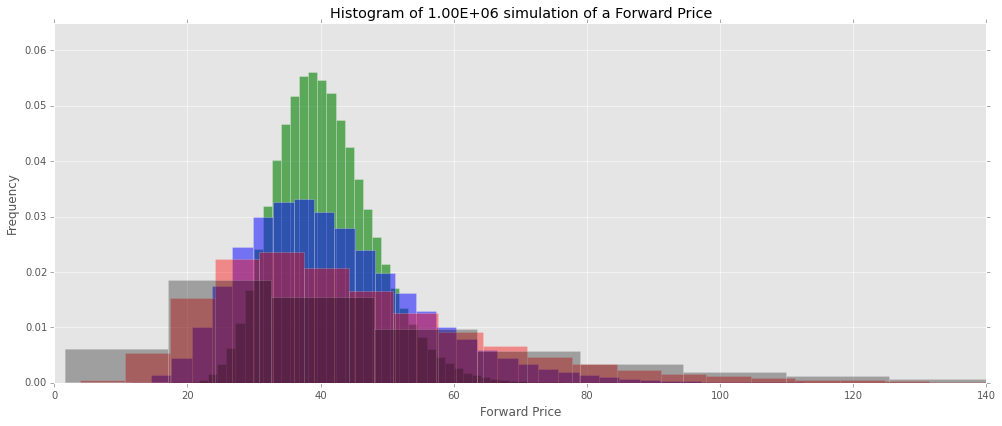

In [32]:
# Example of simulation and ploting of 'tradeable' Forward-Prices 
from matplotlib import rcParams
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

num_simul = 1000000
seed = 12345
num_bins = 60

forwardsimul1 = MCSimulation_2F(40, .15, .05, 50, .05, 30, 0, 30, 60, num_simul, seed)
forwardsimul2 = MCSimulation_2F(40, .25, .15, 50, .35, 30, 0, 30, 60, num_simul, seed)
forwardsimul3 = MCSimulation_2F(40, .35, .25, 50, .65, 30, 0, 30, 60, num_simul, seed)
forwardsimul4 = MCSimulation_2F(40, .45, .35, 50, .95, 30, 0, 30, 60, num_simul, seed)

rcParams['figure.figsize'] = (14, 6)
rcParams['figure.dpi'] = 150
plt.style.use('ggplot')

plt.hist(forwardsimul1, num_bins, normed=1, facecolor='green', alpha=0.6)
plt.hist(forwardsimul2, num_bins, normed=1, facecolor='blue', alpha=0.5)
plt.hist(forwardsimul3, num_bins, normed=1, facecolor='red', alpha=0.4)
plt.hist(forwardsimul4, num_bins, normed=1, facecolor='black', alpha=0.3)

plt.xlabel('Forward Price')
plt.ylabel('Frequency')
plt.axis([0, 140, 0, 0.065])
plt.title(r'Histogram of %.2E simulation of a Forward Price' %num_simul)
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Example of European Call Option valuation using Monte Carlo - 2 factor model

def Call_PriceMC(ForwardPrice, strike, interest_rate,
                STvol, LTvol, meanReverting, corr, 
                maturitydate, valuationdate, 
                deliveryStart, deliveryEnd, 
                size = 1000, seed = None):
    try: 
        ForwardPrice = float(ForwardPrice)
        LTvol = float(LTvol)
        STvol = float(STvol)
        if meanReverting != 0:
            meanReverting = float(meanReverting)
        if corr != 0 :
            corr = float(corr)                                                                                                
        if LTvol < 0 or STvol < 0 or meanReverting < 0 :
            raise ValueError('Negative inputs')
        if deliveryStart > deliveryEnd or valuationdate > maturitydate :
            raise ValueError('Incorrect dates')
        if corr > 1 or corr < -1 :
            raise ValueError('Wrong correlation')
    except: 
        print('Error passing inputs to Call_PriceMC')
        
    TimeToMaturity = (maturitydate - valuationdate) / 365.
    
    forwardsimul = MCSimulation_2F(ForwardPrice, STvol, LTvol, meanReverting, corr, 
                    maturitydate, valuationdate, deliveryStart, deliveryEnd, 
                    size, seed)
    #sum_payoff = 0
    #print"Size: ", size
    payoff = np.maximum(forwardsimul - strike, np.zeros(size,dtype=np.float64))
    #print "Sum_payoff:", payoff 
        
    return (np.exp(-1.0 * interest_rate * TimeToMaturity) * np.sum(payoff) / float(size))

In [88]:
'''
Call_PriceMC(ForwardPrice = 40, strike = 40, interest_rate = 0.01,
                STvol = .25, LTvol = .15, meanReverting = 40 , corr = .75, 
                maturitydate = 30, valuationdate = 0, 
                deliveryStart = 30, deliveryEnd = 31, 
                size = 1000, seed = None):

'''

print 'Call price:', Call_PriceMC(40, 40, 0.00, .25, .15, 40, .75, 30/365., 0, 30, 31, 1000000, 12345)

Call price: 2.640011853


# The Volatility Term Structure

As opposition with the simpler Geometric Brownian Motion widely used in simple financial models, the 2-factor model exhibits a volatility term-structure: this mean that the actual volatility of a particular point in the forward curve depends on the valuation date $t$ and the delivery time $T$ . The volatility term-structure gives how the price behaves depending on how far we are from delivery. It can be seen in different ways.

This section describe how the volatility term-structure given by the instantaneous model specified in the previous section, behaves. As starting point, we can redefine the model to obtain a new expression for the volatilities grouped in a new definition, the **instataneous total volatility**

\begin{equation} 
\frac{dF(t,T)}{F(t,T)}=\sigma_{S}(t,T)e^{-a(T-t)}dB_{S,t}+\sigma_{L}(t,T)dB_{L,t} \approx \Sigma_{inst}(t,T)dZ_t
\end{equation}

where $dZ_t$ is a new Brownian motion, and the instanteous total volatility expression can be obtained from the variance of the previous SDE,

\begin{equation} 
\Sigma_{inst}(t,T)=\sqrt{Var\left\{\frac{dF(t,T)}{F(t,T)}\right\}}=\sqrt{\sigma_S^2e^{-2a(T-t)}+\sigma_L^2+2\rho\sigma_S\sigma_Le^{-a(T-t)}}
\end{equation}

Noting that for energy markets, where the short-term volatility is usually much higher that the long-term
one, previous equation exhibits price characteristics actually observable on the market: The closer we get to delivery, the more volatile the price is, and if our product is far from delivery it follows a geometric brownian motion.





In [40]:
def VolInst2F( STvol, LTvol, meanReverting, 
              valuationdate, maturitydate, deliveryStart, deliveryEnd, corr): 

    try: 
        LTvol = float(LTvol)
        STvol = float(STvol)
        meanReverting = float (meanReverting)
        corr = float(corr)
        if LTvol < 0 or STvol < 0 or meanReverting < 0 or valuationdate > maturitydate:
            raise ValueError('Negative inputs.')
        if corr > 1 or corr < -1 :
            raise ValueError('Incorrect Correlation')
    except: 
        print('Error passing vol inputs')
     
    TimeToMaturity = (maturitydate - valuationdate) / 365.   
    
    if TimeToMaturity == 0 :
        SquareVolInst = 0
    elif meanReverting == 0 : 
        SquareVolInst = LTvol ** 2 + STvol ** 2 + 2 * corr * LTvol * STvol
    else:   
        SquareVolInst = LTvol**2 + STvol**2  * (np.exp(-2*meanReverting*(deliveryStart-valuationdate)/365.)) \
                    /(2*meanReverting*TimeToMaturity) \
                    + 2*STvol*LTvol*corr*(np.exp(-meanReverting*(deliveryStart-maturitydate)/365.)\
                    - np.exp(-meanReverting*(deliveryStart-valuationdate)/365.))/(meanReverting*TimeToMaturity)
        
    return np.sqrt(SquareVolInst)
    

Additionally, we will call the **equivalent volatility** of the forward contract for delivery at time $T$ to the average volatility $\Sigma_{eqv}(t_0, t_m, T )$ of the log-return of $F(t,T)$ between 2 dates $t_0$ (the quotation date) and $t_m$ ($m$
for maturity).

\begin{equation} 
\Sigma_{eq}(t_0,t_m,T)=\sqrt{\frac{V(t_0,t_m,T)}{t_m-t_0}}=\sqrt{ \frac{1}{t_m-t_0} \int_{t_0}^{t_m} \left( \sigma_S^2e^{-2a(T-t)}+\sigma_L^2+2\rho\sigma_S\sigma_Le^{-a(T-t)} \right) dt}
\end{equation}


In [53]:
def volEqM2F( STvol, LTvol, meanReverting, 
             valuationdate, maturitydate, 
             deliveryStart, deliveryEnd, corr, 
             blockSize = 0, granularity = 1 / 365.): 
    try: 
        LTvol = float(LTvol)
        STvol = float(STvol)
        meanReverting = float (meanReverting)
        corr = float(corr)
        if LTvol < 0 or STvol < 0 or meanReverting < 0 :
            raise ValueError('Negative inputs')
        if deliveryStart > deliveryEnd or valuationdate > maturitydate:
            raise ValueError('Wrong dates')
        if corr > 1 or corr < -1 :
            raise ValueError('Incorrect Correlation')
    except: 
        print('Error passing vol inputs')
        
    TimeToMaturity = (maturitydate - valuationdate) / 365.
    psi = PsiFunction(meanReverting, deliveryStart, deliveryEnd)
    if TimeToMaturity == 0 :
        SquareVolEq = 0
    elif meanReverting == 0 : 
        SquareVolEq = LTvol ** 2 + STvol ** 2 + 2 * corr * LTvol * STvol
    else:
        SquareVolEq = LTvol**2 * TimeToMaturity + \
                      STvol**2 * psi **2 * (np.exp(-2*meanReverting*(deliveryStart-maturitydate)/365.)\
                                  - np.exp(-2*meanReverting*(deliveryStart-valuationdate)/365.))\
                                /(2 * meanReverting * TimeToMaturity) + \
                                2 * STvol * LTvol * corr * psi *\
                                (np.exp(-meanReverting*(deliveryStart-maturitydate)/365.) - \
                                np.exp(-meanReverting*(deliveryStart-valuationdate)/365.))\
                                /(meanReverting * TimeToMaturity)
        VForward = np.sqrt(SquareVolEq / TimeToMaturity)
        
    return VForward

In [86]:
volEq = volEqM2F( .25, .15, 40, 0, 30, 30, 31, .85)
print 'Equivalent volatility:', volEq

Equivalent volatility: 0.604231189704


In [87]:
Call_PriceBlack76 = Black(40, 40, 30/365., 0., volEq, 1)
print 'Call price using Black76 Model:', Call_PriceBlack76.Price()
print 'Call price using Monte-Carlo Two-Factor Model:', Call_PriceMC(40, 40, 0., .25, .15, 40, .75, 30/365., 0, 30, 31, 1000000, 12345)

Call price using Black76 Model: 2.76086170727
Call price using Monte-Carlo Two-Factor Model: 2.640011853


In [50]:
class Black(object):
    ''' Class for valuation of European Options (Calls/P.uts) using Black-76 model.
    F0 : float : initial stock/index level
    K : float : strike price
    t : float : maturity (in year fractions)
    r : float : constant risk-free short rate
    vol : float : volatility factor in diffusion term (std)
    CallPut : integer : 1 for a Call, and -1 for a Put
    '''
    
    def __init__(self, F0, K, t, r, vol, CallPut):
        try: 
            self.F0 = float(F0)
            self.K = float(K)
            self.t = float (t)
            self.r = float(r)
            self.vol = float(vol)
            self.CallPut = int(CallPut)           
            if t < 0 or r < 0 or vol < 0:
                raise ValueError('Negative inputs.')
            if CallPut != 1 and CallPut != -1:
                raise ValueError('For a Call: CallPut=1, or -1 for a Put')
        except: 
            print('Error passing option inputs to Black76 function')
        
        
    def Price(self):
        d1 = np.log(self.F0 / self.K) / (self.vol * np.sqrt(self.t)) \
            + 0.5 * self.vol * np.sqrt(self.t)
        d2 = d1 - self.vol * np.sqrt(self.t)
        Price = np.exp(-self.r * self.t) * self.CallPut * \
                    (self.F0 * st.norm(0, 1).cdf(self.CallPut * d1) \
                    - self.K * st.norm(0, 1).cdf(self.CallPut * d2))
        return Price
        
    def Delta(self):
        d1 = np.log(self.F0 / self.K) / (self.vol * np.sqrt(self.t))\
            + 0.5 * self.vol * np.sqrt(self.t)
        Delta = np.exp(-self.r * self.t) * self.CallPut * st.norm(0, 1).cdf(self.CallPut * d1)
        return Delta

    def Gamma(self):
        d1 = np.log(self.F0 / self.K) / (self.vol * np.sqrt(self.t))\
            + 0.5 * self.vol * np.sqrt(self.t)
        Gamma = np.exp(-self.r * self.t) * st.norm(0, 1).pdf(d1)\
            / (self.F0 * self.vol * np.sqrt(self.t))
        return Gamma

    def Vega(self):
        d1 = np.log(self.F0 / self.K) / (self.vol * np.sqrt(self.t)) \
            + 0.5 * self.vol * np.sqrt(self.t)
        Vega = np.exp(-self.r * self.t) * self.F0 \
            * np.sqrt(self.t) * st.norm(0, 1).pdf(d1)
        return Vega
    
    def Rho(self):
        Rho = -self.t * self.Price()
        return Rho

    def Theta(self):
        d1 = np.log(self.F0 / self.K) / (self.vol * np.sqrt(self.t))\
            + 0.5 * self.vol * np.sqrt(self.t)
        d2 = d1 - self.vol * np.sqrt(self.t)
        Theta = np.exp(-self.r * self.t) * \
                (-self.F0 * st.norm(0, 1).pdf(d1) * self.vol / 2. / np.sqrt(self.t) + \
                self.CallPut * self.r * (self.F0 * st.norm(0, 1).cdf(self.CallPut * d1) - \
                               self.K * st.norm(0, 1).cdf(self.CallPut * d2)))
        return Theta